In [10]:
import math
import pandas as pd
import numpy as np
from operator import itemgetter


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics


from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings("ignore")

In [11]:
INFILE = '/Users/zachtsouprakos/documents/msds/msds-422/Module_3/insurance.csv'

TARGET_F = 'TARGET_CLM_FLAG'
TARGET_A = 'TARGET_CLM_AMT'

df = pd.read_csv( INFILE )

dt = df.dtypes
#print( dt )

objList = []
numList = []
for i in dt.index :
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )
    if dt[i] in (["float64","int64"]) : numList.append( i )


"""
FILL IN MISSING WITH THE CATEGORY "MISSING"
"""
for i in objList :
    if df[i].isna().sum() == 0 : continue
    NAME = "IMP_"+i
    df[NAME] = df[i]
    df[NAME] = df[NAME].fillna("MISSING")
    g = df.groupby( NAME )
    df = df.drop( i, axis=1 )

dt = df.dtypes
objList = []
for i in dt.index :
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )



'''
EXPLORE THE CATEGORICAL / OBJECT VARIABLES
'''
df["y_EDU_4"] = (df.EDUCATION.isin( ["a_PhD"] ) + 0 )
df["y_EDU_3"] = (df.EDUCATION.isin( ["a_PhD","b_Masters"] ) + 0)
df["y_EDU_2"] = (df.EDUCATION.isin( ["a_PhD","b_Masters","c_Bachelors"] ) + 0)
df["y_EDU_1"] = (df.EDUCATION.isin( ["a_PhD","b_Masters","c_Bachelors","d_High School"] ) + 0)
df = df.drop( "EDUCATION", axis=1 )
   

dt = df.dtypes
objList = []
for i in dt.index :
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )


for i in objList :
    thePrefix = "z_" + i
    y = pd.get_dummies( df[i], prefix=thePrefix, drop_first=True )   
    #y = pd.get_dummies( df[i], prefix=thePrefix )   
    df = pd.concat( [df, y], axis=1 )
    #df = df.drop( i, axis=1 )


i = "INCOME"
FLAG = "M_" + i
IMP = "IMP_" + i
#print( i )
#print( FLAG )
#print( IMP )
df[ FLAG ] = df[i].isna() + 0
df[ IMP ] = df[ i ]
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Blue Collar"]), IMP ] = 53694
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Student"]), IMP ] = 360
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Clerical"]), IMP ] = 30799
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Doctor"]), IMP ] = 121398
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Home Maker"]), IMP ] = 776
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Lawyer"]), IMP ] = 83230
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["MISSING"]), IMP ] = 109953
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Manager"]), IMP ] = 78589
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Professional"]), IMP ] = 71230
df.loc[ df[IMP].isna(), IMP ] = df[i].median()
df = df.drop( i, axis=1 )
numList.remove(i)


for i in numList :
    if df[i].isna().sum() == 0 : continue
    FLAG = "M_" + i
    IMP = "IMP_" + i
    #print(i)
    #print( df[i].isna().sum() )
    #print( FLAG )
    #print( IMP )
    #print(" ------- ")
    df[ FLAG ] = df[i].isna() + 0
    df[ IMP ] = df[ i ]
    df.loc[ df[IMP].isna(), IMP ] = df[i].median()
    df = df.drop( i, axis=1 )




"""
Remove Outliers
"""


dt = df.dtypes
numList = []
for i in dt.index :
    #print(i, dt[i])
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["float64","int64"]) : numList.append( i )


for i in numList :
    theMean = df[i].mean()
    theSD = df[i].std()
    theMax = df[i].max()
    theCutoff = round( theMean + 3*theSD )
    if theMax < theCutoff : continue
    FLAG = "O_" + i
    TRUNC = "TRUNC_" + i
    df[ FLAG ] = ( df[i] > theCutoff )+ 0
    df[ TRUNC ] = df[ i ]
    df.loc[ df[TRUNC] > theCutoff, TRUNC ] = theCutoff
    df = df.drop( i, axis=1 )






for i in objList:
    df = df.drop( i, axis=1 )

"""
SPLIT DATA
"""

X = df.copy()
X = X.drop( TARGET_F, axis=1 )
X = X.drop( TARGET_A, axis=1 )

Y = df[ [TARGET_F, TARGET_A] ]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=2)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2 )

##print( "FLAG DATA" )
##print( "TRAINING = ", X_train.shape )
##print( "TEST = ", X_test.shape )


F = ~ Y_train[ TARGET_A ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_A ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

#print( Z_train.describe() )
#print( Z_test.describe() )
#print( "\n\n")

F = Z_train[ TARGET_A ] > 25000
Z_train.loc[ F, TARGET_A ] = 25000

F = Z_test[ TARGET_A ] > 25000
Z_test.loc[ F, [TARGET_A] ] = 25000

#print( Z_train.describe() )
#print( Z_test.describe() )
#print( "\n\n")


##print( " ====== ")
##
##print( "AMOUNT DATA" )
##print( "TRAINING = ", W_train.shape )
##print( "TEST = ", Z_test.shape )

In [12]:
X.head()

,y_EDU_3,y_EDU_2,y_EDU_1,z_PARENT1_Yes,z_MSTATUS_Yes,z_SEX_M,z_CAR_USE_Private,z_CAR_TYPE_Panel Truck,z_CAR_TYPE_Pickup,z_CAR_TYPE_SUV,...,O_IMP_YOJ,TRUNC_IMP_YOJ,O_M_HOME_VAL,TRUNC_M_HOME_VAL,O_IMP_HOME_VAL,TRUNC_IMP_HOME_VAL,O_M_CAR_AGE,TRUNC_M_CAR_AGE,O_IMP_CAR_AGE,TRUNC_IMP_CAR_AGE
0,0,1,1,0,1,0,1,0,0,0,...,0,12.0,0,0.0,0,249276.0,0,0.0,0,8.0
1,0,0,1,0,1,1,1,0,0,0,...,0,10.0,0,0.0,0,245993.0,0,0.0,0,1.0
2,0,0,1,0,1,0,1,0,0,1,...,0,0.0,0,0.0,0,0.0,0,0.0,0,10.0
3,0,0,1,0,1,1,0,0,1,0,...,0,12.0,0,0.0,0,274122.0,0,0.0,0,11.0
4,0,0,0,1,0,1,1,0,1,0,...,0,14.0,0,0.0,0,0.0,0,1.0,0,8.0


In [13]:
"""
MODEL ACCURACY METRICS
"""

def getProbAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    probs = MODEL.predict_proba( X )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

def print_ROC_Curve( TITLE, LIST ) :
    fig = plt.figure(figsize=(6,4))
    plt.title( TITLE )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )

def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

In [14]:
def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

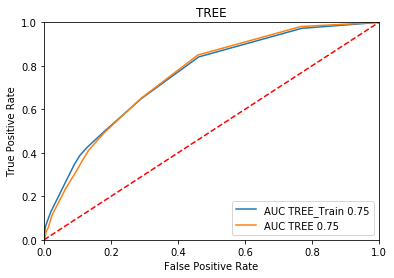

TREE CLASSIFICATION ACCURACY
TREE_Train  =  0.7579177284310157
TREE  =  0.7535177098495875
------




In [15]:
# CRASH PROBABILITY

WHO = "TREE"

CLM = tree.DecisionTreeClassifier( max_depth=4 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

feature_cols = list( X.columns.values )
tree.export_graphviz(CLM,out_file='tree_f.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, class_names=["Good","Bad"]  )
vars_tree_flag = getTreeVars( CLM, feature_cols ) 

In [16]:
# DAMAGES

AMT = tree.DecisionTreeRegressor( max_depth= 4 )
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( AMT, feature_cols ) 
tree.export_graphviz(AMT,out_file='tree_a.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, precision=0  )


TREE_CLM = TEST_CLM.copy()
TREE_AMT = TEST_AMT.copy()

TREE RMSE ACCURACY
TREE_Train  =  4598.4154535975085
TREE  =  4706.726357721267
------




In [18]:
"""
RANDOM FOREST
"""


def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList


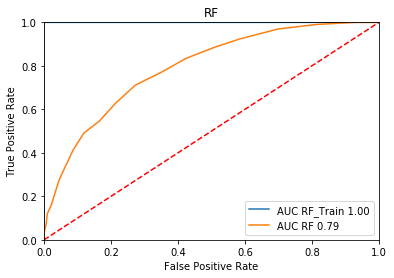

RF CLASSIFICATION ACCURACY
RF_Train  =  0.9985438660356752
RF  =  0.7836001940805434
------




In [19]:
WHO = "RF"

CLM = RandomForestClassifier( n_estimators = 25, random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( CLM, feature_cols )

In [20]:
# DAMAGES

AMT = RandomForestRegressor(n_estimators = 100, random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

##for i in vars_RF_amt :
##    print( i )

RF_CLM = TEST_CLM.copy()
RF_AMT = TEST_AMT.copy()

RF RMSE ACCURACY
RF_Train  =  1839.5551194143786
RF  =  4821.607765604226
------




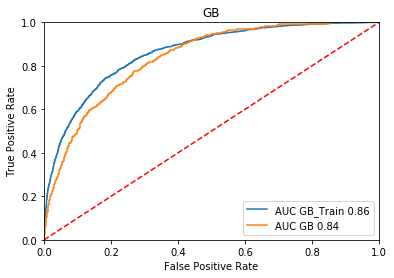

GB CLASSIFICATION ACCURACY
GB_Train  =  0.8167698094891397
GB  =  0.7976710334788938
------




In [21]:
"""
GRADIENT BOOSTING
"""

WHO = "GB"

CLM = GradientBoostingClassifier( random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( CLM, feature_cols )

In [22]:
# DAMAGES

AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )

##for i in vars_RF_amt :
##    print( i )

GB_CLM = TEST_CLM.copy()
GB_AMT = TEST_AMT.copy()

GB RMSE ACCURACY
GB_Train  =  4014.566996799744
GB  =  4864.415710315959
------




# Lets building some logistic and linear regression

In [23]:

def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    print("\nCRASH")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )



def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nDAMAGES")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

### Regression with ALL VARIABLES

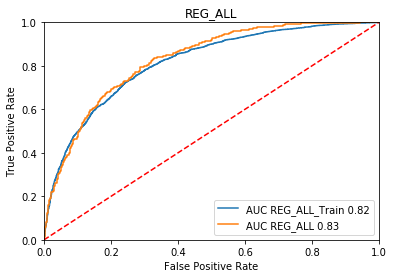

REG_ALL CLASSIFICATION ACCURACY
REG_ALL_Train  =  0.793107632568863
REG_ALL  =  0.7933042212518195
------




In [24]:
"""
REGRESSION ALL VARIABLES
"""

WHO = "REG_ALL"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

                                                                    

In [25]:
# DAMAGES
# the positives and negatives show that there is multicollinearity

AMT = LinearRegression()
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )


varNames = list( X_train.columns.values )

REG_ALL_CLM_COEF = getCoefLogit( CLM, X_train )
REG_ALL_AMT_COEF = getCoefLinear( AMT, X_train )

REG_ALL_CLM = TEST_CLM.copy()
REG_ALL_AMT = TEST_AMT.copy()


REG_ALL RMSE ACCURACY
REG_ALL_Train  =  4651.952900576011
REG_ALL  =  4775.7472347157145
------



CRASH
---------
Total Variables:  64
INTERCEPT  =  -2.3433778015349276
y_EDU_3  =  0.05410058369141999
y_EDU_2  =  -0.4040765820876629
y_EDU_1  =  0.026562040463947906
z_PARENT1_Yes  =  0.4291751828184731
z_MSTATUS_Yes  =  -0.4272384965060973
z_SEX_M  =  0.05157121955473109
z_CAR_USE_Private  =  -0.7678057867518453
z_CAR_TYPE_Panel Truck  =  0.4196377240184907
z_CAR_TYPE_Pickup  =  0.4577120208774516
z_CAR_TYPE_SUV  =  0.6587142575521234
z_CAR_TYPE_Sports Car  =  0.9247593620461603
z_CAR_TYPE_Van  =  0.5439064142082222
z_RED_CAR_yes  =  0.02775996290263211
z_REVOKED_Yes  =  0.7993369052591948
z_URBANICITY_Highly Urban/ Urban  =  2.3382392480203
z_IMP_JOB_Clerical  =  0.007908316518281363
z_IMP_JOB_Doctor  =  -0.6467360829471553
z_IMP_JOB_Home Maker  =  -0.214485961562042
z_IMP_JOB_Lawyer  =  -0.18197062117616294
z_IMP_JOB_MISSING  =  -0.15879404421769017
z_IMP_JOB_Manager  =  -0.793414829

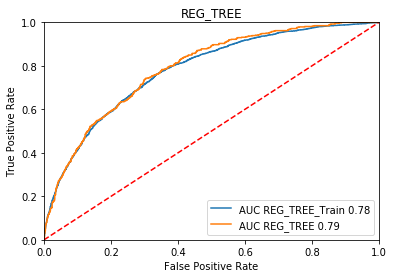

REG_TREE CLASSIFICATION ACCURACY
REG_TREE_Train  =  0.7709015896129111
REG_TREE  =  0.7792333818534692
------




In [26]:
"""
REGRESSION DECISION TREE
"""

WHO = "REG_TREE"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[vars_tree_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[vars_tree_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[vars_tree_flag], Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

In [27]:
# DAMAGES

AMT = LinearRegression()
AMT = AMT.fit( W_train[vars_tree_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[vars_tree_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[vars_tree_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )


varNames = list( X_train.columns.values )

REG_TREE_CLM_COEF = getCoefLogit( CLM, X_train[vars_tree_flag] )
REG_TREE_AMT_COEF = getCoefLinear( AMT, X_train[vars_tree_amt] )

REG_TREE_CLM = TEST_CLM.copy()
REG_TREE_AMT = TEST_AMT.copy()


REG_TREE RMSE ACCURACY
REG_TREE_Train  =  4693.692141493088
REG_TREE  =  4694.091279880061
------



CRASH
---------
Total Variables:  11
INTERCEPT  =  -1.9757508533672095
y_EDU_2  =  -0.6676460340634482
z_PARENT1_Yes  =  0.6096019702381307
TRUNC_OLDCLAIM  =  5.963033314816138e-06
z_CAR_USE_Private  =  -0.7317604262334885
TRUNC_MVR_PTS  =  0.14431615125404476
z_REVOKED_Yes  =  0.698048484583247
z_URBANICITY_Highly Urban/ Urban  =  2.087315416289885
TRUNC_IMP_AGE  =  -0.00416246034171278
TRUNC_KIDSDRIV  =  0.4370442222407392
TRUNC_IMP_HOME_VAL  =  -2.987706966964344e-06

DAMAGES
---------
Total Variables:  11
INTERCEPT  =  2909.603440758595
TRUNC_NPOLICY  =  86.8470684418581
z_PARENT1_Yes  =  660.6185458281427
TRUNC_MVR_PTS  =  60.09010690328601
TRUNC_IMP_AGE  =  9.788537646998515
z_IMP_JOB_Manager  =  -183.7166240959334
TRUNC_IMP_YOJ  =  15.76230690700371
TRUNC_M_HOME_VAL  =  979.0690196350855
TRUNC_IMP_HOME_VAL  =  -0.00012237846814843365
TRUNC_TRAVTIME  =  8.503130915322496
TRUNC_BLU




('TRUNC_BLUEBOOK', 100)
('TRUNC_IMP_INCOME', 99)
('TRUNC_TRAVTIME', 91)
('TRUNC_IMP_AGE', 90)
('TRUNC_IMP_HOME_VAL', 82)
('TRUNC_MVR_PTS', 71)
('TRUNC_OLDCLAIM', 70)
('TRUNC_IMP_YOJ', 59)
('TRUNC_IMP_CAR_AGE', 58)
('TRUNC_TIF', 58)
('TRUNC_CLM_FREQ', 52)
('z_URBANICITY_Highly Urban/ Urban', 51)
('TRUNC_NPOLICY', 35)
('TRUNC_HOMEKIDS', 30)
('z_CAR_USE_Private', 27)
('z_REVOKED_Yes', 23)



('TRUNC_BLUEBOOK', 100)
('TRUNC_IMP_AGE', 65)
('TRUNC_TRAVTIME', 63)
('TRUNC_IMP_INCOME', 63)
('TRUNC_IMP_HOME_VAL', 46)
('TRUNC_OLDCLAIM', 37)
('TRUNC_IMP_YOJ', 36)
('TRUNC_IMP_CAR_AGE', 33)
('TRUNC_TIF', 31)
('TRUNC_MVR_PTS', 28)
('TRUNC_NPOLICY', 19)
('TRUNC_HOMEKIDS', 19)
('TRUNC_CLM_FREQ', 16)


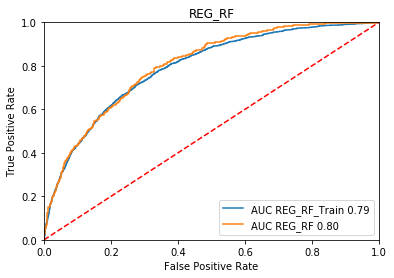

REG_RF CLASSIFICATION ACCURACY
REG_RF_Train  =  0.7774541924523722
REG_RF  =  0.7869966035904901
------




In [28]:
"""
REGRESSION RANDOM FOREST
"""

WHO = "REG_RF"


print("\n\n")
RF_flag = []
for i in vars_RF_flag :
    print(i)
    theVar = i[0]
    RF_flag.append( theVar )

print("\n\n")
RF_amt = []
for i in vars_RF_amt :
    print(i)
    theVar = i[0]
    RF_amt.append( theVar )


CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[RF_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[RF_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[RF_flag], Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


In [29]:
# DAMAGES

AMT = LinearRegression()
AMT = AMT.fit( W_train[RF_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[RF_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[RF_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )


REG_RF_CLM_COEF = getCoefLogit( CLM, X_train[RF_flag] )
REG_RF_AMT_COEF = getCoefLinear( AMT, X_train[RF_amt] )

REG_RF_CLM = TEST_CLM.copy()
REG_RF_AMT = TEST_AMT.copy()

REG_RF RMSE ACCURACY
REG_RF_Train  =  4700.907540503226
REG_RF  =  4700.9775519494315
------



CRASH
---------
Total Variables:  17
INTERCEPT  =  -1.8026925255386663
TRUNC_BLUEBOOK  =  -2.451960235887055e-05
TRUNC_IMP_INCOME  =  -3.4227827354580706e-06
TRUNC_TRAVTIME  =  0.016465912271549317
TRUNC_IMP_AGE  =  -0.0004057247944745956
TRUNC_IMP_HOME_VAL  =  -2.814214372487991e-06
TRUNC_MVR_PTS  =  0.11187953992688245
TRUNC_OLDCLAIM  =  -8.596786880231975e-06
TRUNC_IMP_YOJ  =  -0.016286432324045676
TRUNC_IMP_CAR_AGE  =  -0.02410142021444106
TRUNC_TIF  =  -0.050420672559472336
TRUNC_CLM_FREQ  =  0.19300300343358145
z_URBANICITY_Highly Urban/ Urban  =  2.1489392372211653
TRUNC_NPOLICY  =  -0.06866416758468125
TRUNC_HOMEKIDS  =  0.2008693024900143
z_CAR_USE_Private  =  -0.8686159117813615
z_REVOKED_Yes  =  0.8306987026384873

DAMAGES
---------
Total Variables:  14
INTERCEPT  =  3339.533316679504
TRUNC_BLUEBOOK  =  0.0664087020079204
TRUNC_IMP_AGE  =  7.998446156557934
TRUNC_TRAVTIME  =  8.48




('TRUNC_OLDCLAIM', 100)
('z_URBANICITY_Highly Urban/ Urban', 84)
('y_EDU_2', 37)
('z_CAR_USE_Private', 37)
('TRUNC_IMP_HOME_VAL', 36)
('TRUNC_IMP_AGE', 30)
('TRUNC_BLUEBOOK', 25)
('TRUNC_MVR_PTS', 24)
('TRUNC_IMP_INCOME', 23)
('z_REVOKED_Yes', 22)
('TRUNC_KIDSDRIV', 22)
('TRUNC_TRAVTIME', 21)
('z_PARENT1_Yes', 18)
('z_IMP_JOB_Manager', 15)
('TRUNC_TIF', 11)



('TRUNC_BLUEBOOK', 100)
('TRUNC_IMP_INCOME', 42)
('TRUNC_TRAVTIME', 37)
('TRUNC_IMP_AGE', 37)
('TRUNC_OLDCLAIM', 25)
('TRUNC_NPOLICY', 23)
('TRUNC_IMP_HOME_VAL', 22)
('TRUNC_IMP_CAR_AGE', 21)
('TRUNC_HOMEKIDS', 13)
('z_PARENT1_Yes', 12)
('TRUNC_IMP_YOJ', 8)
('TRUNC_MVR_PTS', 7)
('TRUNC_M_HOME_VAL', 7)
('TRUNC_TIF', 6)


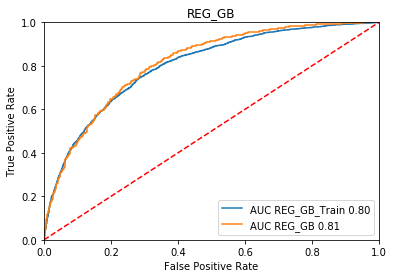

REG_GB CLASSIFICATION ACCURACY
REG_GB_Train  =  0.7853415847591312
REG_GB  =  0.7913634158175643
------




In [30]:
"""
REGRESSION GRADIENT BOOSTING
"""

WHO = "REG_GB"


print("\n\n")
GB_flag = []
for i in vars_GB_flag :
    print(i)
    theVar = i[0]
    GB_flag.append( theVar )

print("\n\n")
GB_amt = []
for i in vars_GB_amt :
    print(i)
    theVar = i[0]
    GB_amt.append( theVar )


CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[GB_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[GB_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[GB_flag], Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


In [31]:
# DAMAGES

AMT = LinearRegression()
AMT = AMT.fit( W_train[GB_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[GB_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[GB_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_GB_CLM_COEF = getCoefLogit( CLM, X_train[GB_flag] )
REG_GB_AMT_COEF = getCoefLinear( AMT, X_train[GB_amt] )

REG_GB_CLM = TEST_CLM.copy()
REG_GB_AMT = TEST_AMT.copy()


REG_GB RMSE ACCURACY
REG_GB_Train  =  4691.87337543683
REG_GB  =  4694.079351528451
------



CRASH
---------
Total Variables:  16
INTERCEPT  =  -2.1915157669087004
TRUNC_OLDCLAIM  =  6.358859942791686e-06
z_URBANICITY_Highly Urban/ Urban  =  2.353836321029529
y_EDU_2  =  -0.43161206701997956
z_CAR_USE_Private  =  -0.852697876583251
TRUNC_IMP_HOME_VAL  =  -2.340322289030073e-06
TRUNC_IMP_AGE  =  3.590151125913225e-05
TRUNC_BLUEBOOK  =  -2.4655086973383414e-05
TRUNC_MVR_PTS  =  0.13031966490724953
TRUNC_IMP_INCOME  =  -3.080311228947285e-06
z_REVOKED_Yes  =  0.6780406031943661
TRUNC_KIDSDRIV  =  0.4408282261838556
TRUNC_TRAVTIME  =  0.016614772700741267
z_PARENT1_Yes  =  0.7221408188825503
z_IMP_JOB_Manager  =  -0.6535784364493709
TRUNC_TIF  =  -0.05304238774456223

DAMAGES
---------
Total Variables:  15
INTERCEPT  =  3007.1176686517356
TRUNC_BLUEBOOK  =  0.06687885460596549
TRUNC_IMP_INCOME  =  0.000625097299498368
TRUNC_TRAVTIME  =  8.991183513569423
TRUNC_IMP_AGE  =  11.1546058094445

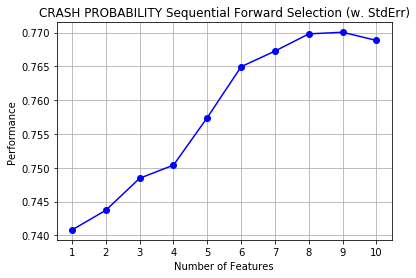

 ................... 
argmax
feature_names    (0, 1, 3, 4, 5, 6, 7, 8, 9)
avg_score                           0.770052
Name: 9, dtype: object
 ................... 
('0', '1', '3', '4', '5', '6', '7', '8', '9')
y_EDU_2
z_PARENT1_Yes
z_CAR_USE_Private
TRUNC_MVR_PTS
z_REVOKED_Yes
z_URBANICITY_Highly Urban/ Urban
TRUNC_IMP_AGE
TRUNC_KIDSDRIV
TRUNC_IMP_HOME_VAL


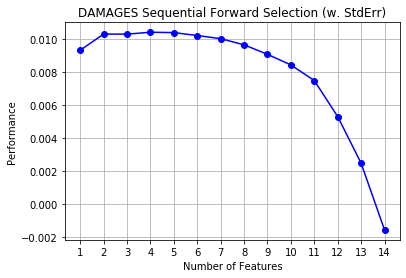

 ................... 
argmax
feature_names    (0, 3, 7, 9)
avg_score           0.0103887
Name: 4, dtype: object
 ................... 
('0', '3', '7', '9')
TRUNC_BLUEBOOK
TRUNC_IMP_AGE
TRUNC_IMP_CAR_AGE
z_PARENT1_Yes


In [32]:
"""
REGRESSION STEPWISE
"""

U_train = X_train[ vars_tree_flag ]
stepVarNames = list( U_train.columns.values )
maxCols = U_train.shape[1]

sfs = SFS( LogisticRegression( solver='newton-cg', max_iter=100 ),
           k_features=( 1, maxCols ),
           forward=True,
           floating=False,
           cv=3
           )
sfs.fit(U_train.values, Y_train[ TARGET_F ].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('CRASH PROBABILITY Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

finalStepVars = []
for i in stepVars :
    index = int(i)
    try :
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass

for i in finalStepVars :
    print(i)

U_train = X_train[ finalStepVars ]
U_test = X_test[ finalStepVars ]



V_train = W_train[ GB_amt ]
stepVarNames = list( V_train.columns.values )
maxCols = V_train.shape[1]

sfs = SFS( LinearRegression(),
           k_features=( 1, maxCols ),
           forward=True,
           floating=False,
           scoring = 'r2',
           cv=5
           )
sfs.fit(V_train.values, Z_train[ TARGET_A ].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('DAMAGES Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

finalStepVars = []
for i in stepVars :
    index = int(i)
    try :
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass

for i in finalStepVars :
    print(i)

V_train = W_train[ finalStepVars ]
V_test = W_test[ finalStepVars ]

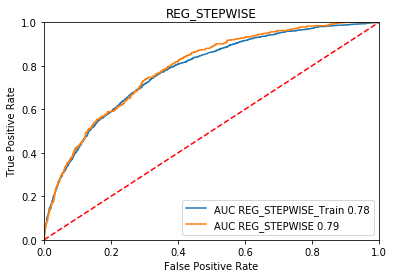

REG_STEPWISE CLASSIFICATION ACCURACY
REG_STEPWISE_Train  =  0.7702948671277757
REG_STEPWISE  =  0.7811741872877244
------


REG_STEPWISE RMSE ACCURACY
REG_STEPWISE_Train  =  4702.702270366729
REG_STEPWISE  =  4682.2640390735205
------



CRASH
---------
Total Variables:  10
INTERCEPT  =  -1.97368813821167
y_EDU_2  =  -0.6681931841259511
z_PARENT1_Yes  =  0.609087279619471
z_CAR_USE_Private  =  -0.732169145308725
TRUNC_MVR_PTS  =  0.1494730576741128
z_REVOKED_Yes  =  0.7530643647903669
z_URBANICITY_Highly Urban/ Urban  =  2.097416456124803
TRUNC_IMP_AGE  =  -0.00419146120771304
TRUNC_KIDSDRIV  =  0.43716849733466523
TRUNC_IMP_HOME_VAL  =  -2.9935726725963535e-06

DAMAGES
---------
Total Variables:  5
INTERCEPT  =  3711.598895772435
TRUNC_BLUEBOOK  =  0.06809088396184616
TRUNC_IMP_AGE  =  12.480018957563018
TRUNC_IMP_CAR_AGE  =  -25.095442330675382
z_PARENT1_Yes  =  672.2709769404379


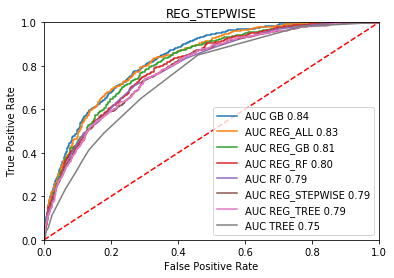

ALL CLASSIFICATION ACCURACY
GB  =  0.7976710334788938
REG_ALL  =  0.7933042212518195
REG_GB  =  0.7913634158175643
REG_RF  =  0.7869966035904901
RF  =  0.7836001940805434
REG_STEPWISE  =  0.7811741872877244
REG_TREE  =  0.7792333818534692
TREE  =  0.7535177098495875
------


ALL DAMAGE MODEL ACCURACY
REG_STEPWISE  =  4682.2640390735205
REG_GB  =  4694.079351528451
REG_TREE  =  4694.091279880061
REG_RF  =  4700.9775519494315
TREE  =  4706.726357721267
REG_ALL  =  4775.7472347157145
RF  =  4821.607765604226
GB  =  4864.415710315959
------




In [33]:

"""
REGRESSION 
"""

WHO = "REG_STEPWISE"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( U_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


# DAMAGES

AMT = LinearRegression()
AMT = AMT.fit( V_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_STEP_CLM_COEF = getCoefLogit( CLM, U_train )
REG_STEP_AMT_COEF = getCoefLinear( AMT, V_train )

REG_STEP_CLM = TEST_CLM.copy()
REG_STEP_AMT = TEST_AMT.copy()






# Create a list of models
ALL_CLM = [ TREE_CLM, RF_CLM, GB_CLM, REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM, REG_GB_CLM, REG_STEP_CLM ]

# Sort these guys by the fourth element in the list which is AUC
# Sort a lists of lists and don't want to go by the first element in the list
ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( WHO, ALL_CLM ) 

# get the accuracy of the damages and sort those as well
ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )


ALL_AMT = [ TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT, REG_GB_AMT, REG_STEP_AMT ]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL DAMAGE MODEL ACCURACY", ALL_AMT )

# in the real world, run these models again with different random_seed numbers
## good models will have similar results!!!!